In [1]:
import pickle
import sys

import numpy as np
import tensorflow as tf
from IPython.core.display import HTML
from sklearn.model_selection import train_test_split
from tensorflow.python.framework.errors_impl import NotFoundError

from src.cfd import CFD
from src.dataset import X_TIME, TIME_STEP
from src.gauss_hist import get_gauss_stats
from src.models import optimal_model_builder_all_ch, optimal_model_builder_ch_2_11
from src.network_utils import train_model as _base_train_model, plot_difference_hist, plot_history, compare_results, \
    gaussian_kernel

PWD = '../../../..'
sys.path.append(PWD)

tf.get_logger().setLevel('ERROR')

In [2]:
N_JOBS = 16

TRAIN_DATASET_PATHS = [
    PWD + '/data/dataset/dataset.pkl',
    PWD + '/data/dataset/dataset_r355445.pkl',
    PWD + '/data/dataset/dataset_r355558.pkl',
    PWD + '/data/dataset/dataset_r355680.pkl',
    PWD + '/data/dataset/dataset_r355769.pkl',
]

TEST_DATASET_PATH = PWD + '/data/dataset/dataset_r354332.pkl'

PRINT_PCOV = False

N_BASELINE = 6

LR = 0.05
ES_MIN_DELTA = 0.01

N_EPOCHS = 3000
BATCH_SIZE = 8192
LOSS_WEIGHT = 1000

CFD_THRESHOLD_SPACE = np.arange(0.12, 0.25, 0.005)
OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD + '/data/tmp/many_channels_tests/optimal_cfd_thresholds_r354332_2022.pkl'

TRAIN_TEST_SPLIT_RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
train_datasets = []
for path in TRAIN_DATASET_PATHS:
    with open(path, 'rb') as file:
        train_datasets.append(pickle.load(file))

with open(TEST_DATASET_PATH, 'rb') as file:
    test_dataset = pickle.load(file)

# Utils

In [4]:
def model_predict(model: tf.keras.Model, X: np.ndarray):
    Y_heatmap_pred = model.predict(X, batch_size=BATCH_SIZE)

    y_pred = np.empty(Y_heatmap_pred.shape[0])
    for i, y in enumerate(Y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    return y_pred

In [5]:
def train_model(model, name, X_train, y_train, X_val, y_val, lr=LR, train=False, n_epochs=N_EPOCHS, verbose=1,
                batch_size=BATCH_SIZE, lr_patience=6, es_patience=50, es_min_delta=ES_MIN_DELTA,
                loss_weights=LOSS_WEIGHT):
    return _base_train_model(model, name, 'many_channels_tests/trained_on_2022_sep_r354332', X_train, y_train, X_val, y_val, lr,
                             train, n_epochs, verbose, batch_size, lr_patience, es_patience, es_min_delta, loss_weights,
                             root=PWD + '/data')

# Load optimal CFD thresholds

In [6]:
# from src.cfd import find_optimal_cfd_threshold
#
# optimal_cfd_thresholds = {}
# for plane, channel in sorted(test_dataset.keys()):
#     print(f'Processing p={plane}, ch={channel}...')
#     all_X, all_y = test_dataset[(plane, channel)][0], test_dataset[(plane, channel)][1]
#     # X_train, _, y_train, _ = train_test_split(all_X, all_y, test_size=TEST_SIZE, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)
#
#     optimal_cfd_threshold = find_optimal_cfd_threshold(CFD_THRESHOLD_SPACE, N_BASELINE, all_X, all_y, X_TIME, n_jobs=N_JOBS, plot=False)
#     optimal_cfd_thresholds[(plane, channel)] = optimal_cfd_threshold
#
# with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'wb') as file:
#     pickle.dump(optimal_cfd_thresholds, file)

In [7]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

Optimal thresholds:
(1,  2): 0.170
(1, 11): 0.165
(2,  2): 0.205
(2, 11): 0.145
(3,  2): 0.135
(3, 11): 0.140


# Train the network

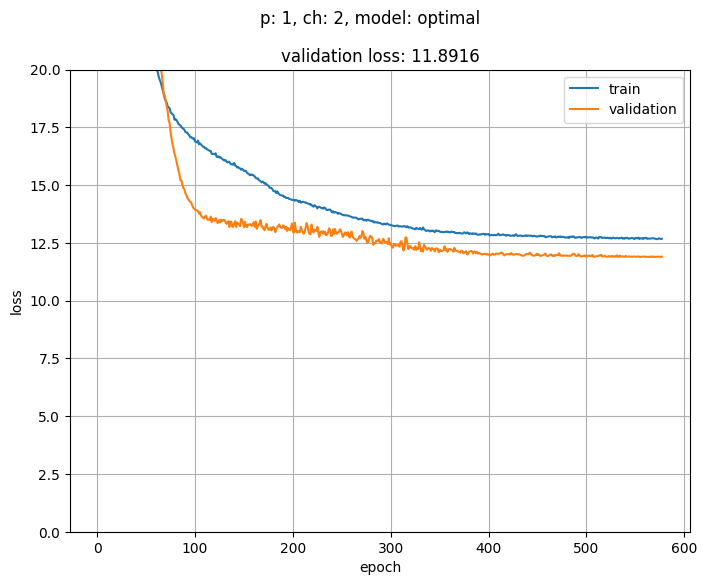

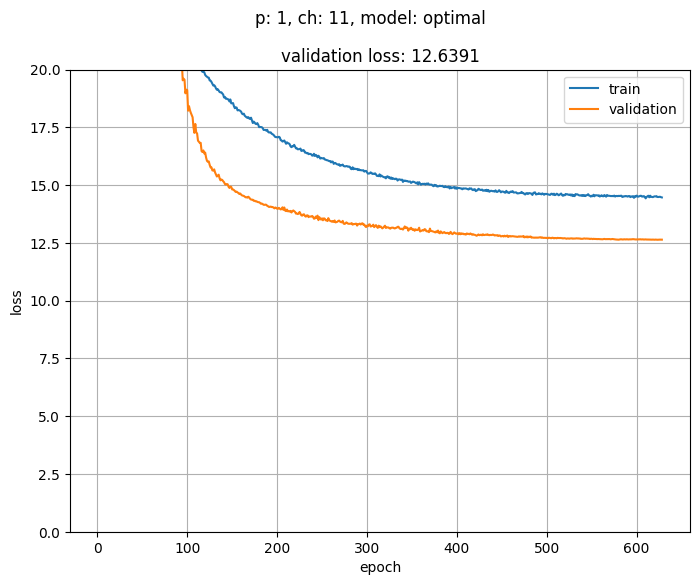

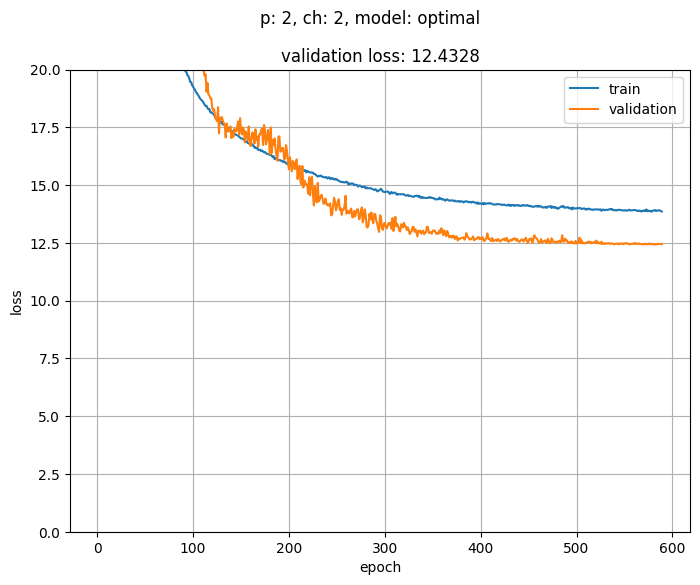

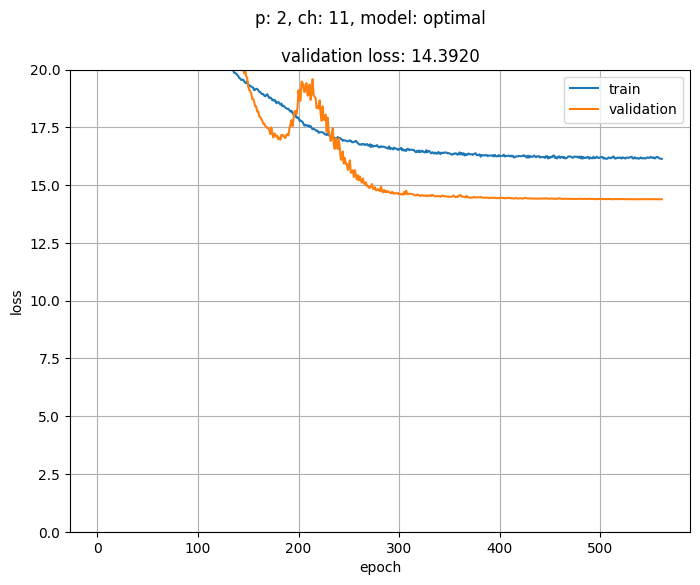

Could not find the model for (3, 2). Setting train=True
Epoch 1/3000
7/7 [==============================] - 1s 102ms/step - loss: 32.8840 - val_loss: 209830.3125 - lr: 0.0500
Epoch 7/3000
7/7 [==============================] - 1s 102ms/step - loss: 29.4219 - val_loss: 65548.1562 - lr: 0.0500
Epoch 8/3000
7/7 [==============================] - 1s 115ms/step - loss: 26.7419 - val_loss: 16413.8242 - lr: 0.0500
Epoch 9/3000
7/7 [==============================] - 1s 113ms/step - loss: 24.5066 - val_loss: 4015.3804 - lr: 0.0500
Epoch 10/3000
7/7 [==============================] - 1s 114ms/step - loss: 23.4636 - val_loss: 1825.1210 - lr: 0.0500
Epoch 11/3000
7/7 [==============================] - 7s 221ms/step - loss: 371.2140 - val_loss: 22486.0312 - lr: 0.0500
Epoch 2/3000
7/7 [==============================] - 1s 103ms/step - loss: 79.5705 - val_loss: 6826431.0000 - lr: 0.0500
Epoch 3/3000
7/7 [==============================] - 1s 102ms/step - loss: 52.2070 - val_loss: 9367163.0000 - lr: 0

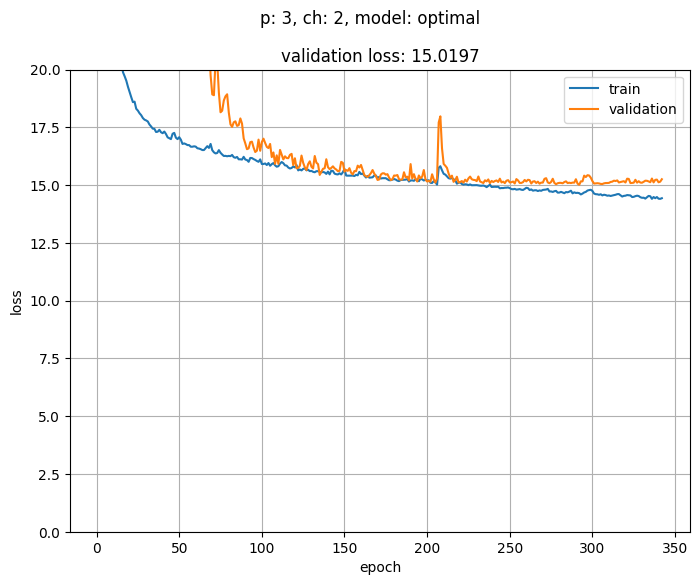

Could not find the model for (3, 11). Setting train=True
Epoch 1/3000
5/5 [==============================] - 3s 291ms/step - loss: 5803.8374 - val_loss: 3938009600.0000 - lr: 0.0500
Epoch 2/3000
5/5 [==============================] - 1s 125ms/step - loss: 439.0032 - val_loss: 1132841856.0000 - lr: 0.0500
Epoch 3/3000
5/5 [==============================] - 1s 124ms/step - loss: 330.2025 - val_loss: 8408575.0000 - lr: 0.0500
Epoch 4/3000
5/5 [==============================] - 1s 122ms/step - loss: 288.9372 - val_loss: 7145059.0000 - lr: 0.0500
Epoch 5/3000
5/5 [==============================] - 1s 126ms/step - loss: 246.1186 - val_loss: 128891.1562 - lr: 0.0500
Epoch 6/3000
5/5 [==============================] - 1s 125ms/step - loss: 206.4599 - val_loss: 14618.4805 - lr: 0.0500
Epoch 7/3000
5/5 [==============================] - 1s 126ms/step - loss: 175.1557 - val_loss: 458.1831 - lr: 0.0500
Epoch 8/3000
5/5 [==============================] - 1s 108ms/step - loss: 153.7907 - val_loss: 2

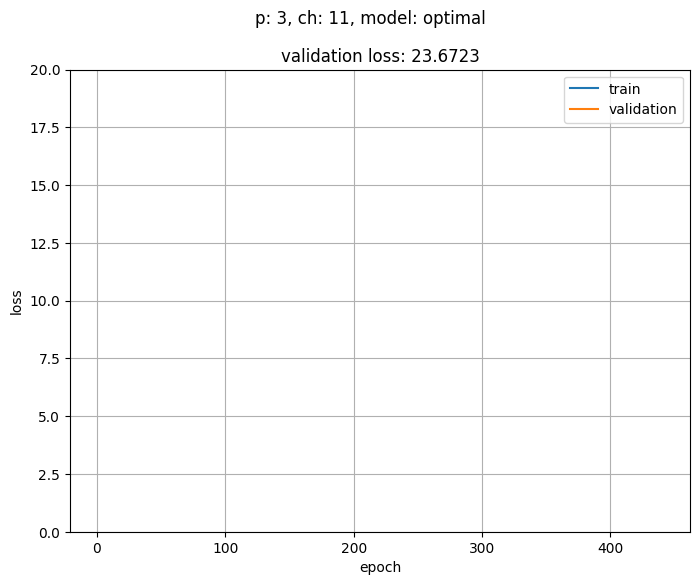

In [8]:
models = {}
for plane, channel in sorted(train_datasets[0].keys()):
    display(HTML(f'<h3>Plane: {plane}, channel: {channel}</h3>'))

    train_X_list, train_y_list, test_X_list, test_y_list = [], [], [], []
    for dataset in train_datasets:
        X, y = dataset[(plane, channel)]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,
                                                            random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

        Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
        Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

        train_X_list.append(X_train)
        train_y_list.append(Y_heatmap_train)
        test_X_list.append(X_test)
        test_y_list.append(Y_heatmap_test)

    X_train_all = np.concatenate(train_X_list)
    y_train_all = np.concatenate(train_y_list)
    X_test_all = np.concatenate(test_X_list)
    y_test_all = np.concatenate(test_y_list)

    # Network
    model = optimal_model_builder_ch_2_11()
    try:
        history = train_model(model, f'optimal_{plane}_{channel}', X_train=X_train_all, y_train=y_train_all,
                              X_val=X_test_all, y_val=y_test_all, train=False)
    except (FileNotFoundError, NotFoundError, ValueError):
        print(f'Could not find the model for ({plane}, {channel}). Setting train=True')
        history = train_model(model, f'optimal_{plane}_{channel}', X_train=X_train_all, y_train=y_train_all,
                              X_val=X_test_all, y_val=y_test_all, train=True)

    plot_history(history, f'p: {plane}, ch: {channel}, model: optimal', ymax=20)

    models[(plane, channel)] = model

# Test

Processing p=1, ch=2...
1/1 [==============================] - 0s 192ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 81.80 ps
   optimal: 73.88 ps (improvement: 9.68 %)
Processing p=1, ch=11...
1/1 [==============================] - 0s 198ms/step
       CFD: 92.08 ps
   optimal: 83.38 ps (improvement: 9.45 %)
Processing p=2, ch=2...
1/1 [==============================] - 0s 216ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


       CFD: 86.10 ps
   optimal: 75.85 ps (improvement: 11.91 %)
Processing p=2, ch=11...
1/1 [==============================] - 0s 250ms/step
       CFD: 91.39 ps
   optimal: 85.13 ps (improvement: 6.85 %)
Processing p=3, ch=2...
1/1 [==============================] - 0s 214ms/step
       CFD: 99.12 ps
   optimal: 79.19 ps (improvement: 20.11 %)
Processing p=3, ch=11...
1/1 [==============================] - 0s 226ms/step
       CFD: 119.48 ps
   optimal: 115.42 ps (improvement: 3.40 %)


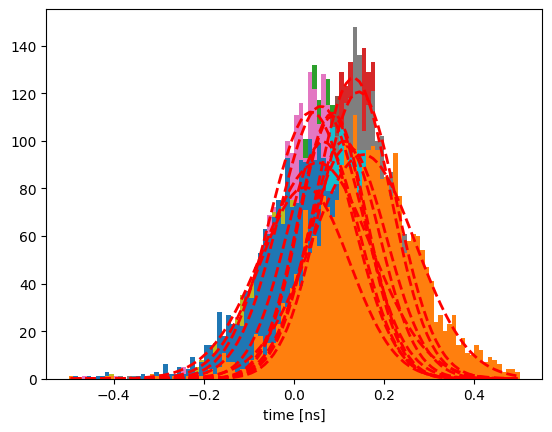

In [9]:
improvements = {}
for (plane, channel), (all_X, all_y) in test_dataset.items():
    print(f'Processing p={plane}, ch={channel}...')

    _, X_test, _, y_test = train_test_split(all_X, all_y, test_size=TEST_SIZE, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_thresholds[(plane, channel)])
    y_pred_cfd = cfd.predict(X_TIME, X_test)
    std_cfd, _, _ = plot_difference_hist(y_test, y_pred_cfd, show=False, close=False)

    model = models[(plane, channel)]
    y_pred_model = model_predict(model, X_test)
    std_model, _, _ = plot_difference_hist(y_test, y_pred_model, show=False, close=False)

    compare_results([std_model], ["optimal"], std_cfd)
    improvements[(plane, channel)] = (std_cfd, std_model, 1 - std_model / std_cfd)

In [10]:
print('Improvements:')
for (plane, channel), improv in improvements.items():
    print(
        f'({plane:>1}, {channel:>2}) CFD: {improv[0] * 1000:6.2f} ps, NN: {improv[1] * 1000:6.2f} ({improv[2] * 100:5.2f} %)')

Improvements:
(1,  2) CFD:  81.80 ps, NN:  73.88 ( 9.68 %)
(1, 11) CFD:  92.08 ps, NN:  83.38 ( 9.45 %)
(2,  2) CFD:  86.10 ps, NN:  75.85 (11.91 %)
(2, 11) CFD:  91.39 ps, NN:  85.13 ( 6.85 %)
(3,  2) CFD:  99.12 ps, NN:  79.19 (20.11 %)
(3, 11) CFD: 119.48 ps, NN: 115.42 ( 3.40 %)
